In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,Dense, Dropout, LSTM, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import pickle
import random
import os
import pandas as pd
import re
pd.set_option('display.max_colwidth', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Load the data

In [3]:
train = pd.read_pickle('/content/drive/MyDrive/ai_assignment_aidock/data/train_data_clean.pkl')
round(train['label'].value_counts()/len(train)*100,2)

0    79.71
1    20.29
Name: label, dtype: float64

In [4]:

test = pd.read_pickle('/content/drive/MyDrive/ai_assignment_aidock/data/test_data_clean.pkl')
round(test['label'].value_counts()/len(test)*100,2)

0    79.69
1    20.31
Name: label, dtype: float64

In [5]:
#Sentences array for train and test sets + target variable for train and test
text_train = train['remove_stop_words']
y_train = train['label']

text_test = test['remove_stop_words']
y_test = test['label']


##Count hyper parameters

In [6]:
#vocab_size count
results = set()
train.remove_stop_words.str.split().apply(results.update)
vocab_size = len(results)
vocab_size

2284

In [7]:
maxSequenceLength_train = train['clean_paragraph_len'].max()
maxSequenceLength_test = test['clean_paragraph_len'].max()
maxSequenceLength_test, maxSequenceLength_train #(81, 121),

(121, 121)

##Prepare sequence and additional features

###First, commented cell makes simple sent2vec. Second, not commented cell makes TFIDF sequences vectors

In [8]:
# def sent2vec(texts, max_sequence_length,vocab_size):
#     """ Create a union train set vocabulary and turn text in set
#     into  padded sequences (word --> num )
#     :param texts: series of prepared strings
#            max_sequence_length: int max len of sentence in series
#     :return ndArray with transformed series of text to int
#             with 0-padding up to max_sequence_length"""
        
#     tokenizer = Tokenizer(num_words=vocab_size)
#     tokenizer.fit_on_texts(texts)
# #     print('vocab len',vocab_size,len(tokenizer.word_index))
    
#     # Turn text into  padded sequences (word --> num )
#     text_sequences = tokenizer.texts_to_sequences(texts)
#     return pad_sequences(text_sequences, maxlen=max_sequence_length,
#                          dtype="int32", padding="post", value=0)
    
    

In [9]:
def tfidf(texts,vocab_size):
    """ Create a union train set vocabulary and turn text in set
    into  padded sequences (word --> num )
    :param texts: series of prepared strings
           max_sequence_length: int max len of sentence in series
    :return ndArray with transformed series of text to int
            with 0-padding up to max_sequence_length"""
        
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(texts)
#     print('vocab len',vocab_size,len(tokenizer.word_index))
    
    # Turn text into  padded sequences (word --> num )
    text_sequences = tokenizer.texts_to_sequences(texts)
    
    return tokenizer.sequences_to_matrix(text_sequences, mode='tfidf')



In [10]:
#for test nlp
# sent2vec_test = sent2vec(text_test, maxSequenceLength_train,vocab_size)

# index_max_len_sent = train[train['clean_paragraph_len'] == maxSequenceLength_train].index 
# sent2vec_train[index_max_len_sent]
X_meta_test = test[['sent_count','num_count','clean_paragraph_len','verb_count','contains_pron']]
# sent2vec_test.shape, X_meta_test.shape

In [11]:
#for train nlp
# sent2vec_train = sent2vec(text_train, maxSequenceLength_train,vocab_size)

# index_max_len_sent = train[train['clean_paragraph_len'] == maxSequenceLength_train].index 
# sent2vec_train[index_max_len_sent]
X_meta_train = train[['sent_count','num_count','clean_paragraph_len','verb_count','contains_pron']]
# sent2vec_train.shape, X_meta_train.shape

embedding_dimensions = 128
BATCH_SIZE= 128 
EPOCHS=200
THRESHOLD=0.5

In [12]:
# sent2vec_train.shape, X_meta_train.shape

In [13]:
tf_idf_train = tfidf(text_train,vocab_size)
tf_idf_test = tfidf(text_test,vocab_size)

In [14]:
tf_idf_train.shape, tf_idf_test.shape

((3844, 2284), (960, 2284))

## Create, build, train the model

In [15]:
from tensorflow.keras import regularizers

def get_model(tf_idf_train,X_meta_train, results,embedding_dimensions):
    
    # nlp_input = Input(shape=(sent2vec_train.shape[1],)) 

    tf_idf_input = Input(shape=(tf_idf_train.shape[1],))

    meta_input = Input(shape=(X_meta_train.shape[1],))

    # emb1 = Embedding(output_dim=embedding_dimensions, 
    #                 input_dim=len(results) + 1, 
    #                 input_length=sent2vec_train.shape[1],
    #                 mask_zero=True)(nlp_input)  # Use masking to handle the variable sequence lengths

    emb2 = Embedding(output_dim=embedding_dimensions, 
                        input_dim=len(results) + 1, 
                        input_length=tf_idf_train.shape[1],
                        mask_zero=True)(tf_idf_input)  # Use masking to handle the variable sequence lengths

    # emb_concat =  tf.concat([emb1, emb2], axis=0)    

    nlp_out = LSTM(128)(emb2) #

    concat = tf.concat([nlp_out, meta_input], axis=1) 

    classifier = Dense(32,kernel_regularizer=regularizers.l2(0.005),activation='relu')(concat) 

    drop = Dropout(0.3)(classifier) #0.2 to avoid overfit

    output = Dense(1,kernel_regularizer=regularizers.l2(0.005), activation='sigmoid')(drop) 

    model = Model(inputs=[tf_idf_input , meta_input], outputs=[output])

    
    return model

In [16]:
concat_lstm = get_model(tf_idf_train,X_meta_train, results,embedding_dimensions)

In [17]:
concat_biLstm.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2284)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 2284, 128)    292480      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 128)          131584      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
______________________________________________________________________________________________

In [18]:
concat_lstm.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.Recall(),
                           tf.keras.metrics.Precision(),
                           'accuracy',
                           tf.keras.metrics.AUC()])

In [19]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss'
          , mode='min')
callbacks=[es]
history = concat_lstm.fit([tf_idf_train,X_meta_train], y_train
                    , batch_size=BATCH_SIZE
                    , epochs=EPOCHS
                    , validation_split=0.2
                    , callbacks=callbacks)

Epoch 1/200
25/25 [==============================] - 144s 6s/step - loss: 0.8140 - recall: 0.0822 - precision: 0.2632 - accuracy: 0.7623 - auc: 0.5824 - val_loss: 0.5429 - val_recall: 0.1722 - val_precision: 1.0000 - val_accuracy: 0.8375 - val_auc: 0.9576
Epoch 2/200
25/25 [==============================] - 134s 5s/step - loss: 0.5474 - recall: 0.2901 - precision: 0.9177 - accuracy: 0.8529 - auc: 0.8885 - val_loss: 0.4170 - val_recall: 0.4768 - val_precision: 1.0000 - val_accuracy: 0.8973 - val_auc: 0.9884
Epoch 3/200
25/25 [==============================] - 135s 5s/step - loss: 0.4300 - recall: 0.4462 - precision: 0.9235 - accuracy: 0.8804 - auc: 0.9553 - val_loss: 0.3060 - val_recall: 0.7417 - val_precision: 1.0000 - val_accuracy: 0.9493 - val_auc: 0.9905
Epoch 4/200
25/25 [==============================] - 135s 5s/step - loss: 0.3409 - recall: 0.5972 - precision: 0.9519 - accuracy: 0.9129 - auc: 0.9658 - val_loss: 0.2477 - val_recall: 0.9139 - val_precision: 0.9583 - val_accuracy: 0

##Evaluate the model

In [20]:
score = concat_lstm.evaluate([tf_idf_test,X_meta_test], y_test,
                       batch_size=BATCH_SIZE, verbose=1)
print()
print(u'Model Loss score: {}'.format(score[0]))
print(u'Model Recall class 1 Evaluation : {}'.format(score[1]))


8/8 [==============================] - 3s 431ms/step - loss: 0.1068 - recall: 0.9282 - precision: 0.9628 - accuracy: 0.9781 - auc: 0.9967

Model Loss score: 0.1067771166563034
Model Recall class 1 Evaluation : 0.928205132484436


In [21]:
for i,j in zip(['Loss','Recall','Precision','Accuracy','AUC'],score):
  print(i,j)

Loss 0.1067771166563034
Recall 0.928205132484436
Precision 0.9627659320831299
Accuracy 0.9781249761581421
AUC 0.9967353940010071


##Plot the loss. (On the legend are loss and recall values)

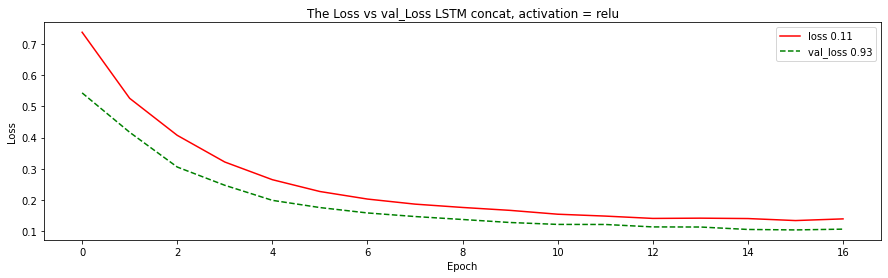

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore')
warnings.filterwarnings('ignore')

#plot the accuracy 
plt.figure(figsize=(15,4))
plt.plot(history.history['loss'], 'r', label=f'loss {round(score[0],2)}')
plt.plot(history.history['val_loss'], 'g--', label=f'val_loss {round(score[1],2)}')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('The Loss vs val_Loss LSTM concat, activation = relu')
plt.legend(loc='best');

### Saving/restoring the model

In [29]:
# concat_biLstm.save('/content/drive/MyDrive/ai_assignment_aidock/data/my_model-92-11-tfidf.h5')

# New Section

In [24]:
# new_model = tf.keras.models.load_model('my_model3.h5')

In [25]:
# new_model.summary()

## All in one cell

### The code doesn't run on my laptop - not enough powers, only googlecollab


### different in dropout layer: 0.3 in the model abow and  0.2 in the model below

In train 0    79.71
1    20.29
Name: label, dtype: float64
In test 0    79.69
1    20.31
Name: label, dtype: float64
The max_sequence_len is 121
The vocab_size is 2284
Epoch 1/200
25/25 [==============================] - 143s 6s/step - loss: 3.3670 - recall_1: 0.8009 - precision_1: 0.2089 - accuracy: 0.3254 - auc_1: 0.5010 - val_loss: 0.8640 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_accuracy: 0.7997 - val_auc_1: 0.5462
Epoch 2/200
25/25 [==============================] - 137s 5s/step - loss: 0.8740 - recall_1: 0.0902 - precision_1: 0.2778 - accuracy: 0.7618 - auc_1: 0.5441 - val_loss: 0.6239 - val_recall_1: 0.0331 - val_precision_1: 0.7143 - val_accuracy: 0.8075 - val_auc_1: 0.7894
Epoch 3/200
25/25 [==============================] - 134s 5s/step - loss: 0.6827 - recall_1: 0.1184 - precision_1: 0.4875 - accuracy: 0.7889 - auc_1: 0.6867 - val_loss: 0.5424 - val_recall_1: 0.0397 - val_precision_1: 1.0000 - val_accuracy: 0.8114 - val_auc_1: 0.8930
Epoch 4/200
25/25 [=

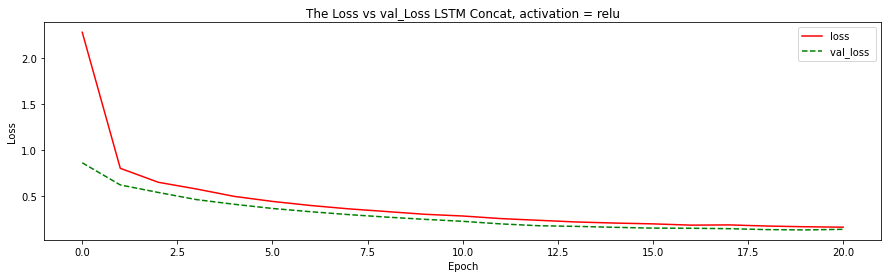

The model is saved to /content/drive/MyDrive/ai_assignment_aidock/data/my_model.h5


In [27]:
import tensorflow
import matplotlib.pyplot as plt
import pandas as pd

BATCH_SIZE = 128
EPOCHS = 200 
MODEL_NAME = '/content/drive/MyDrive/ai_assignment_aidock/data/my_model.h5'
TRAIN_DATA_CLEAN = '/content/drive/MyDrive/ai_assignment_aidock/data/train_data_clean.pkl'
TEST_DATA_CLEAN = '/content/drive/MyDrive/ai_assignment_aidock/data/test_data_clean.pkl'
EMBEDDING_DIM = 128
THRESHOLD=0.5

def tfidf(texts, vocab_size):
    """ Create a union train set vocabulary and turn text in set
    into  padded sequences (word --> num )
    :param texts: series of prepared strings
           max_sequence_length: int max len of sentence in series
    :return ndArray with transformed series of text to arrays of float Tf-IdF coefficients"""

    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(texts)

    # Turn text into  padded sequences (word --> num )
    text_sequences = tokenizer.texts_to_sequences(texts)

    return tokenizer.sequences_to_matrix(text_sequences, mode='tfidf')




def get_model(tf_idf_train, X_meta_train, results,
              embedding_dimensions=EMBEDDING_DIM):  # TODO move it into model_train.py
    """
    The function creates the model for 2 different input data:
    NLP set and additional features not NLP set
    Layers: Embedding - TFIDF MATRIX Use masking to handle the variable sequence lengths,
            BiLSTM, concatenation of 2 data types,
            Dense/fully connected layer with activation function "relu",
            Dropout layer to avoid overfitting,
            Dense/fully connected layer with activation function "sigmoid"
            All hyper-parameters as constants are in config.py
    :params tf_idf_train: ndArray(ndArray(int)) - a set with tfidf vectors
    :params X_meta_train: ndArray(int))- a set with non-nlp features
    :params results: set{str} - word vocabulary of the train set (config.VOCAB_SIZE=2263)
    :params embedding_dimensions:int hyper-parameter, can be done as = int(len(results)**0.25)
    :return a model
    """
    nlp_input = Input(shape=(tf_idf_train.shape[1],))

    meta_input = Input(shape=(X_meta_train.shape[1],))

    emb = Embedding(output_dim=embedding_dimensions,
                    input_dim=len(results) + 1,
                    input_length=tf_idf_train.shape[1],
                    mask_zero=True)(nlp_input)

    nlp_out = LSTM(128)(emb)

    concat = tensorflow.concat([nlp_out, meta_input], axis=1)

    classifier = Dense(32, kernel_regularizer=regularizers.l2(0.005), activation='relu')(concat)

    drop = Dropout(0.2)(classifier)

    output = Dense(1, kernel_regularizer=regularizers.l2(0.005), activation='sigmoid')(drop)
    model = Model(inputs=[nlp_input, meta_input], outputs=[output])

    return model



def model_train(train_data_clean_path= TRAIN_DATA_CLEAN, test_data_clean_path=TEST_DATA_CLEAN):
    """Read train and test data from pkl files
            count max len sent/sequence
            count vocabulary size
            transform data into sequences
            split data into nlp and meta sets for test and train
            train the model, evaluate and plot loss vs val_loss
            save the model into 'data/lstm_concat-86-85.h5' file
    :param train_data_clean_path: str - default  config.TRAIN_DATA_CLEAN
    :param test_data_clean_path: str - default config.TEST_DATA_CLEAN
    :return void
    """

    train_data_clean = pd.read_pickle(train_data_clean_path)
    print(f'In train {round(train_data_clean.label.value_counts() / len(train_data_clean) * 100, 2)}')

    test_data_clean = pd.read_pickle(test_data_clean_path)
    print(f'In test {round(test_data_clean.label.value_counts() / len(test_data_clean) * 100, 2)}')

    # max len sequence count will be constanta at the end  (it is 121 in train - we will use it)
    max_sequence_length = train_data_clean['clean_paragraph_len'].max()
    print(f'The max_sequence_len is {max_sequence_length}')
    # vocab_size - count in train set
    results = set()
    train_data_clean.remove_stop_words.str.split().apply(results.update)
    vocab_size = len(results)
    print(f'The vocab_size is {vocab_size}')

    # sent to sequence only for  NLP TRAIN
    tf_idf_train = tfidf(train_data_clean.remove_stop_words, vocab_size)
    # for other features train
    X_meta_train = train_data_clean[['sent_count', 'num_count', 'clean_paragraph_len', 'verb_count','contains_pron']]
    y_train = train_data_clean['label']

    # for NLP TEST
    tf_idf_test = tfidf(test_data_clean.remove_stop_words, vocab_size)
    # for other features test
    X_meta_test = test_data_clean[['sent_count', 'num_count', 'clean_paragraph_len', 'verb_count','contains_pron']]
    y_test = test_data_clean['label']

    # create and train the MODEL
    model = get_model(tf_idf_train, X_meta_train, results)
    model.compile(optimizer='adam',
                          loss='binary_crossentropy',
                          metrics=[tensorflow.keras.metrics.Recall(),
                                   tensorflow.keras.metrics.Precision(),
                                   'accuracy',
                                   tensorflow.keras.metrics.AUC()])
    es = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss')
    history = model.fit([tf_idf_train, X_meta_train],
                                y_train,
                                batch_size=BATCH_SIZE,
                                epochs=EPOCHS,
                                validation_split=0.2,
                                callbacks=[es])
    # evaluate the model
    score = model.evaluate([tf_idf_test, X_meta_test], y_test, batch_size=BATCH_SIZE, verbose=1)
    print(f'Model Loss score: {round(score[0], 2)}')
    print(f'Model Recall score: {round(score[1], 2)}')
    print(f'Model Precision score: {round(score[2], 2)}')
    print(f'Model Accuracy Evaluation : {round(score[3], 2)}')
    print(f'Model AUC Evaluation : {round(score[4], 2)}')


    # plot the loss
    plt.figure(figsize=(15, 4))
    plt.plot(history.history['loss'], 'r', label=f'loss  ')
    plt.plot(history.history['val_loss'], 'g--', label=f'val_loss ')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('The Loss vs val_Loss LSTM Concat, activation = relu')
    plt.legend(loc='best')
    plt.show()

    model.save(MODEL_NAME)
    print(f'The model is saved to {MODEL_NAME}')


# if __name__ == '__main__':
model_train()
